<a href="https://colab.research.google.com/github/LeDucDiLac/anti-spoofing-w-dinov2/blob/main/Dinov2_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision.transforms import v2
import cv2
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)

dino_name = "dinov2_vitg14"
dino_model = torch.hub.load("facebookresearch/dinov2", dino_name)
dino_model.to(device).eval()


using cpu


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

In [11]:
from torch import nn

class LargerNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LargerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 256)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

if(dino_name == "dinov2_vitg14"):
  input_dim = 1536
elif dino_name == "dinov2_vitl14":
  input_dim = 1024
elif dino_name == "dinov2_vitb14":
  input_dim = 768
elif dino_name == "dinov2_vits14":
  input_dim = 384

output_dim = 2
nn_model_path = "/content/drive/MyDrive/antispoofing/modelg14_4l.pth"
nn_model = LargerNN(input_dim, output_dim)
nn_model.load_state_dict(torch.load(nn_model_path, weights_only=True, map_location=device))
nn_model.eval()


img_size = 224
transform = v2.Compose([
    v2.Resize((img_size,img_size)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [18]:
from PIL import Image
def infer(image_path):
    """
    Perform inference on a single image.

    Args:
        image_path (str): Path to the image.

    Returns:
        int: Predicted class (0 or 1).
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Extract features using DINOv2
    with torch.no_grad():
        features = dino_model(input_tensor)

    # Pass features to your trained NN
    with torch.no_grad():
        features = features.cpu().numpy()
        features = torch.tensor(features, dtype=torch.float32).to(device)
        outputs = nn_model(features)
        _, predicted_class = torch.max(outputs, 1)

    return predicted_class.item()

Upload file and predict

Saving 20241129_1701524417.jpg to 20241129_1701524417 (1).jpg


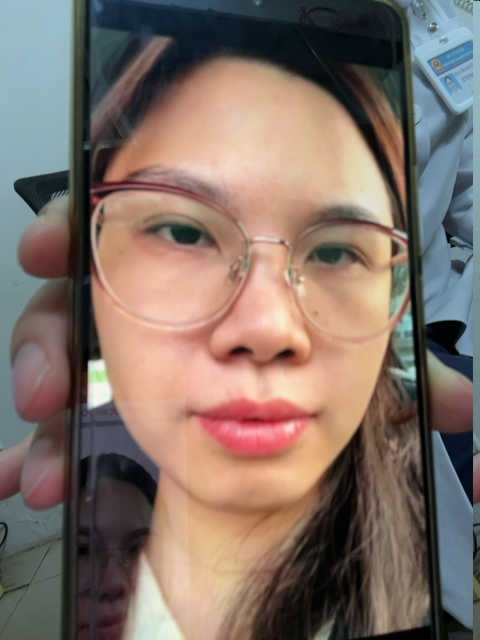

Spoof
Time elapsed:  11.433196783065796


In [41]:
from google.colab import files
uploaded = files.upload()
begin = time.time()
uploaded_path = list(uploaded)[0]
predicted, _ = infer(uploaded_path)
predicted_string = "Spoof" if predicted == 1 else "Live"
img = cv2.imread(uploaded_path)
cv2_imshow(img)
print(predicted_string)
print("Time elapsed: ", time.time() - begin)

dict_keys(['20241129_1701524417.jpg'])

'20241129_1701524417.jpg'

dict_keys(['foo', 'hello'])